In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
%matplotlib inline
import seaborn as sns
from scipy import signal
%pylab inline
figsize(17, 8)

Populating the interactive namespace from numpy and matplotlib


## Reading data

In [5]:
patients = 10
electrodes = 256
samples = 201

healthy = []
sick = []
for i in range(patients):
    healthy.append(sio.loadmat('data/S{:02d}.mat'.format(i+1))['data'])
    sick.append(sio.loadmat('data/P{:02d}.mat'.format(i+1))['data'])
    print('S{:02d}.mat:'.format(i+1), healthy[-1].shape, 'P{:02d}.mat:'.format(i+1), sick[-1].shape)

S01.mat: (657, 256, 201) P01.mat: (894, 256, 201)
S02.mat: (407, 256, 201) P02.mat: (687, 256, 201)
S03.mat: (809, 256, 201) P03.mat: (700, 256, 201)
S04.mat: (746, 256, 201) P04.mat: (1596, 256, 201)
S05.mat: (697, 256, 201) P05.mat: (857, 256, 201)
S06.mat: (769, 256, 201) P06.mat: (944, 256, 201)
S07.mat: (789, 256, 201) P07.mat: (947, 256, 201)
S08.mat: (800, 256, 201) P08.mat: (901, 256, 201)
S09.mat: (628, 256, 201) P09.mat: (539, 256, 201)
S10.mat: (767, 256, 201) P10.mat: (931, 256, 201)


## Ejercicio A1:

In [3]:
figsize(17, 8)
electrodes = [8, 44, 80, 131, 185]
def spectrumForEpochs(person):
    X = []
    Y = []
    Z = []
    for i, epoch in enumerate(person):
        y, z = signal.welch(np.sum(epoch[electrodes],axis=0) / len(electrodes), fs=250)
        cut_index = next((i for i,v in enumerate(y) if v > 50)) # filtro a frecuencias no filtradas en el preprocesamiento
        X.append([i]*len(y[:cut_index]))
        Y.append(y[:cut_index])
        Z.append(z[:cut_index])
    plt.pcolor(X, Y, Z, vmin=0, vmax=1e-11, antialiaseds=False)
    plt.colorbar()
    plt.show()

### - Persona sana

/Users/chcuneo/ThePost/Personal/Facu/p3venv/lib/python3.5/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


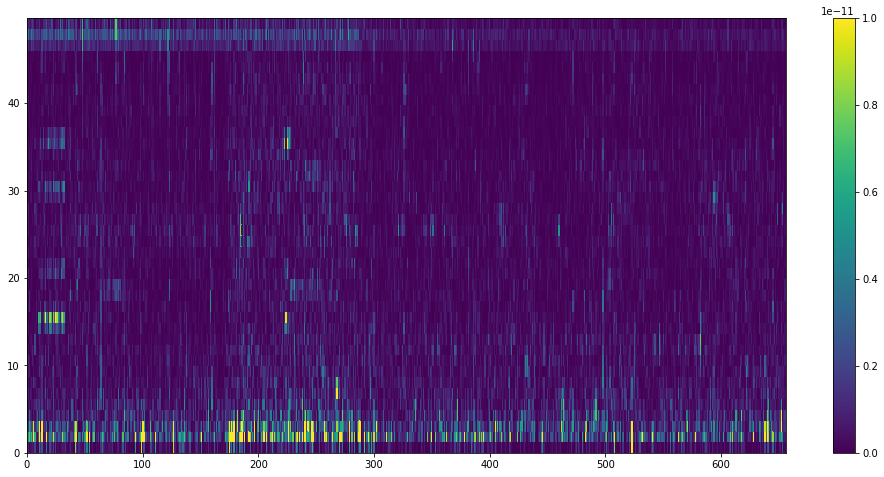

In [4]:
spectrumForEpochs(healthy[0])

### - Persona enferma

/Users/chcuneo/ThePost/Personal/Facu/p3venv/lib/python3.5/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


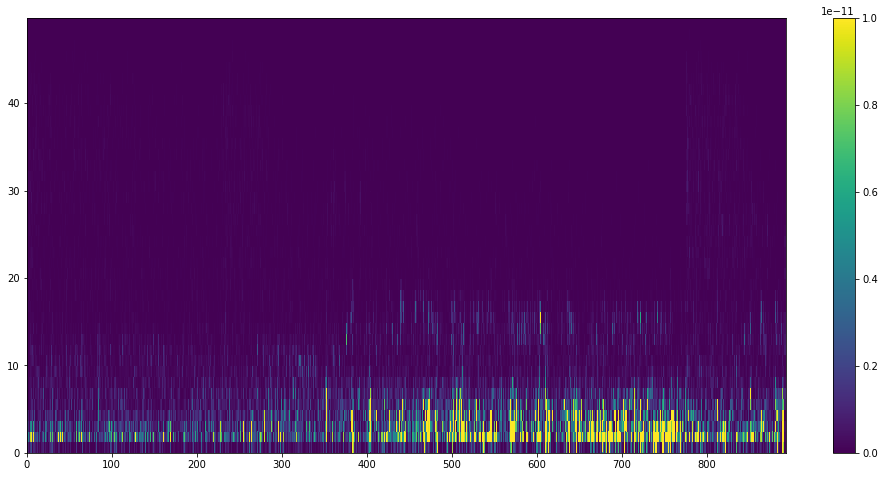

In [5]:
spectrumForEpochs(sick[0])

## Ejercicio B

In [58]:
'''
2 CP F(2 chris)
3 Choclo H(1 tha, 1 chr, 1 max)
2 Pollo al verdeo H(2 tha)
1 QC F(1 nachito)
1 Carne suave F(1 nachito)
2 Porteñas F(2 nachito)
1 Verdura sb H(max)
1 Pollo champ F(max)
'''
from collections import defaultdict
labels = ('delta', 'theta', 'alpha', 'beta', 'gamma')

def getBandIntervals(frequencies):
    intervals = []
    intervals.append(('delta', (0, next((i for i,v in enumerate(frequencies) if v >= 4)) - 1)))
    intervals.append(('theta', (intervals[-1][1][1] + 1, next((i for i,v in enumerate(frequencies) if v >= 8)) - 1)))
    intervals.append(('alpha', (intervals[-1][1][1] + 1, next((i for i,v in enumerate(frequencies) if v >= 13)) - 1)))
    intervals.append(('beta', (intervals[-1][1][1] + 1, next((i for i,v in enumerate(frequencies) if v >= 30)) - 1)))
    intervals.append(('gamma', (intervals[-1][1][1] + 1,  len(frequencies) - 1)))
    return intervals

def bandsForPerson(person):
    Y = None
    Z = defaultdict(list)
    cut_index = None
    for epoch in person:
        y, z = signal.welch(np.sum(epoch,axis=0) / len(epoch), fs=250)
        cut_index = cut_index or next((i for i,v in enumerate(y) if v > 50)) # filtro a frecuencias no filtradas en el preprocesamiento
        if Y is None:
            Y = y[:cut_index]
            intervals = getBandIntervals(Y)
        if not np.array_equal(Y, y[:cut_index]):
            print('ATR')
        for label, interval in intervals:
            Z[label].append(np.sum(z[interval[0]:interval[1]+1]))
    
    '''
    Delta < 4 Hz
    4 Hz <= Theta < 8 Hz
    8 Hz <= Alpha < 13 Hz
    13 Hz <= Beta < 30 Hz
    30 Hz <= Gamma < Nyquist
    '''
    return Z

healthy_bands = []
sick_bands = []
for person in healthy:
    healthy_bands.append(bandsForPerson(person))
for person in sick:
    sick_bands.append(bandsForPerson(person))

/Users/chcuneo/ThePost/Personal/Facu/p3venv/lib/python3.5/site-packages/scipy/signal/spectral.py:1637: UserWarning: nperseg = 256 is greater than input length  = 201, using nperseg = 201
  .format(nperseg, input_length))


In [64]:
def plotBands(people):
    figsize(17, 8)
    ncol = 5
    nrow = int(len(people)/ncol) 
    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)
    ax = axs.flatten()
    x = [0,1,2,3,4]
    plt.setp(axs, xticks=x, xticklabels=labels)
    for i, person in enumerate(people):
        ax[i].bar([labels.index(k) for k in person.keys()], [np.sum(v)/len(v) for v in person.values()])
    

### Sanos

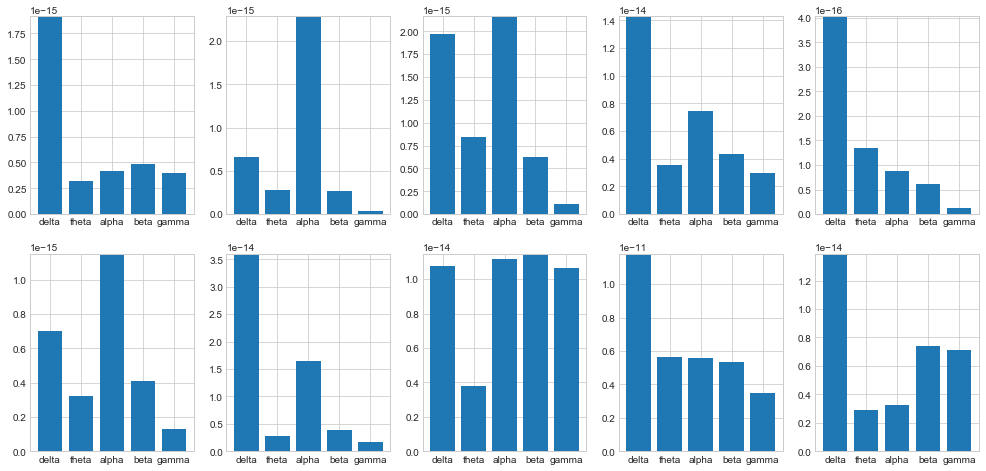

In [50]:
plotBands(healthy_bands)

### Enfermos

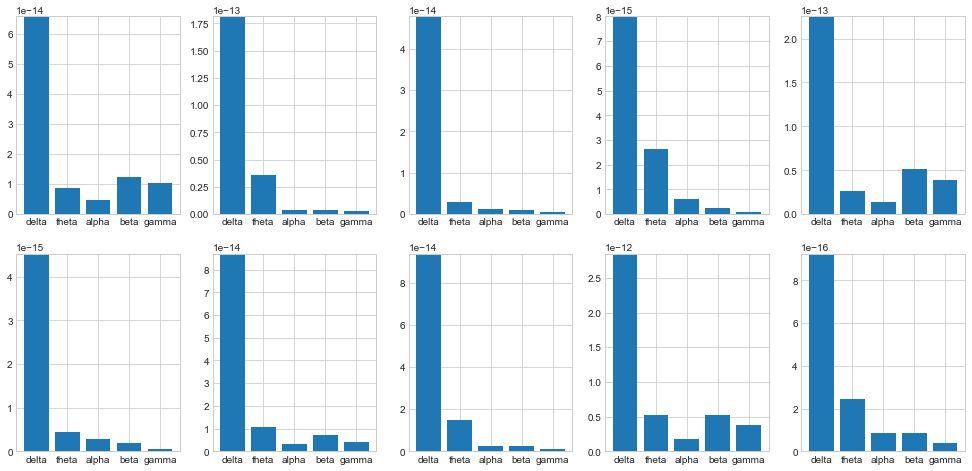

In [51]:
plotBands(sick_bands)

## Ejercicio C

In [103]:
def plot_categorical(people, min_val=0, max_val=1):
    figsize(20, 8)
    sns.set_style("whitegrid")
    y = [np.sum(bands['alpha'])/len(bands['alpha']) for bands in people]
    fig, axs = plt.subplots(nrows=1, ncols=7)
    ax = axs.flatten()
    sns_plots = []
    sns_plots.append(sns.stripplot(y=y, ax=ax[0]))
    print('ploted strip')
    sns_plots.append(sns.swarmplot(y=y, ax=ax[1]))
    print('ploted swarm')
    sns_plots.append(sns.boxplot(y=y, ax=ax[2]))
    print('ploted box')
    sns_plots.append(sns.violinplot(y=y, ax=ax[3], scale='count'))
    print('ploted violin')
    sns_plots.append(sns.lvplot(y=y, ax=ax[4]))
    print('ploted lvplot')
    sns_plots.append(sns.pointplot(y=y, ax=ax[5]))
    print('ploted point')
    sns_plots.append(sns.barplot(y=y, ax=ax[6]))
    print('ploted bar')


ploted strip
ploted swarm
ploted box
ploted violin
ploted lvplot
ploted point
ploted bar


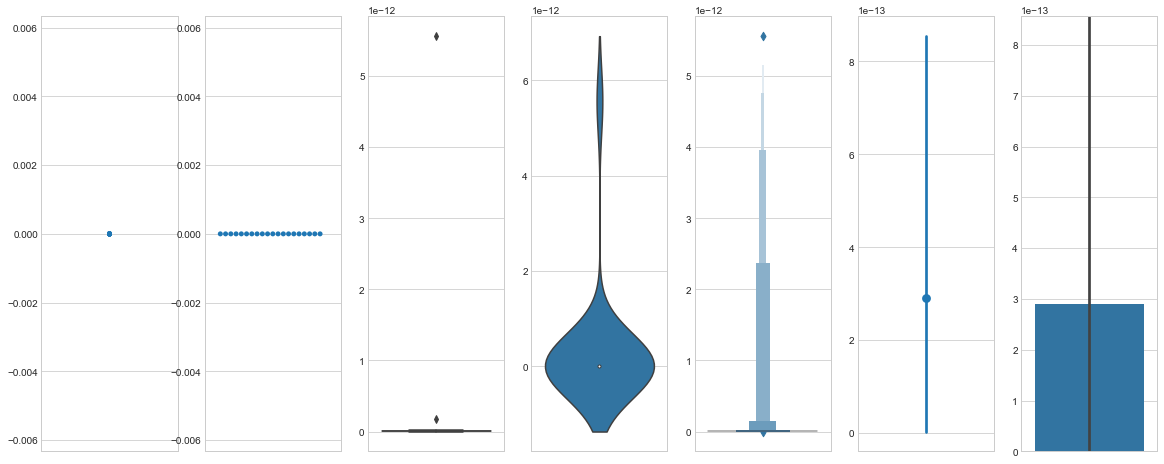

In [104]:
plot_categorical(sick_bands+healthy_bands)

### Elección de grafico
Estaria entre box plot y el violin plot, despues zafaria solo el lvplot, pero el resto pierde mucho poder analitico.
Lo bueno del boxplot es que te muestra información que no se puede calcular mentalmente (mediana y cuartiles) pero es mucho mas intuitivo ver el violinplot porque, a pesar de no ver esta información, se puede ver bien la distribución de los datos de forma muy natural, y de hecho, se pueden ver ciertos patrones que se perderian en un boxplot.

## Ejercicio D

In [62]:
def plotViolionBands(people, skip=[]):
    figsize(20, 8)
    sns.set_style("whitegrid")
    y = []
    x = []
    for li, band in enumerate(labels):
        x.extend([li]*len(people))
        y.extend([np.sum(bands[band])/len(bands[band]) for bands in people])
        
    ax = sns.violinplot(x=x, y=y, scale='count')
    plt.setp(ax, xticks=range(len(labels)), xticklabels=labels)

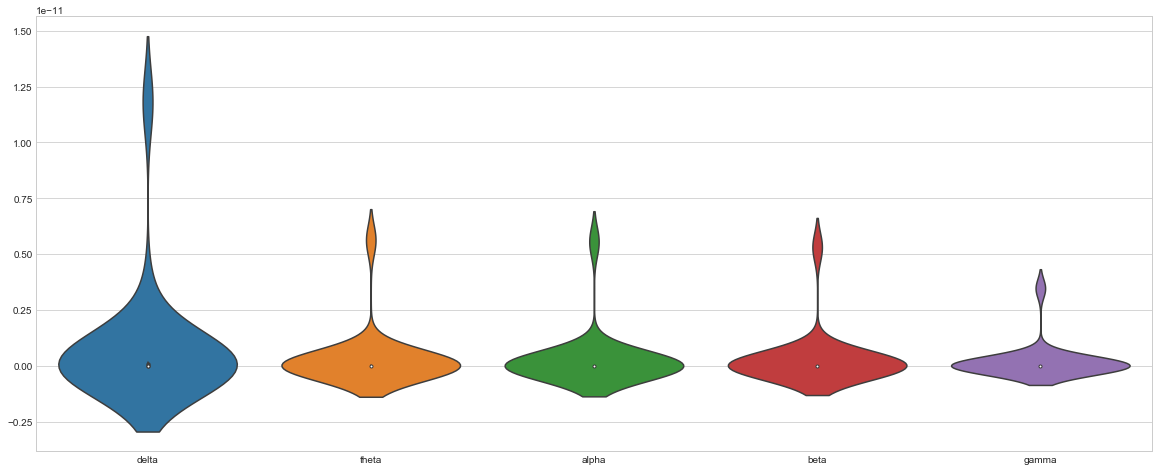

In [115]:
plotViolionBands(healthy_bands+sick_bands)

## Ejercicio E

In [72]:
def normalize_bands(people):
    normalized_people = []
    for person in people:
        full_pwrs = np.sum(list(person.values()), axis=0)
        normalized_people.append({k:v/full_pwrs for k, v in person.items()})
    return normalized_people

normalized_healthy = normalize_bands(healthy_bands)
normalized_sick = normalize_bands(sick_bands)

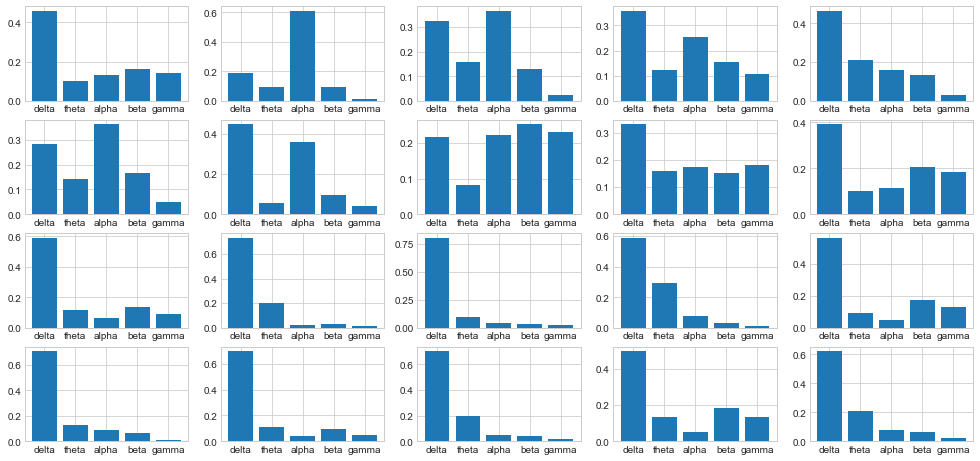

In [73]:
plotBands(normalized_healthy+normalized_sick)

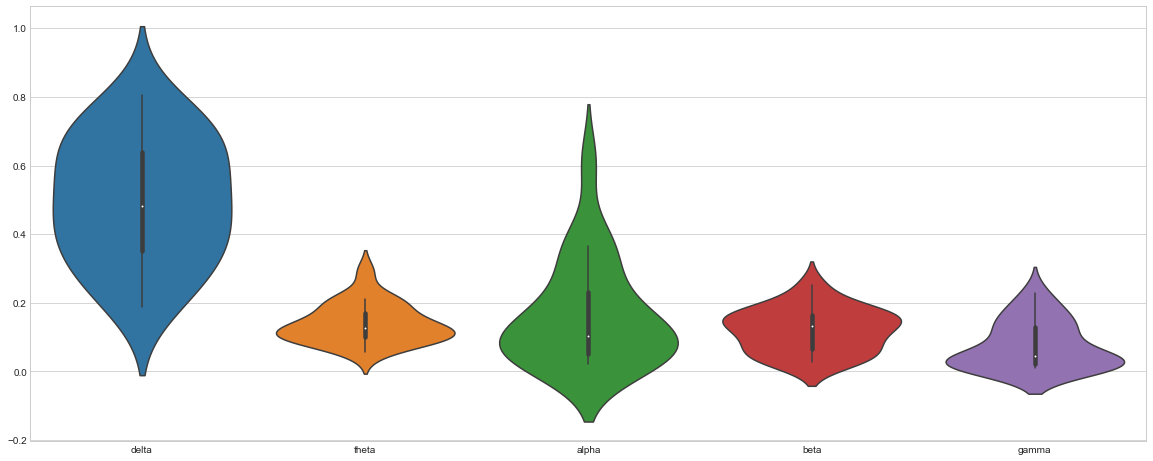

In [74]:
plotViolionBands(normalized_healthy+normalized_sick)

# Análisis de Información

## Ejercicio A

Aca calculo ciertos valores que me van a ayudar a saber la cantidad de bins optimo para este estudio

In [11]:
import random
from math import sqrt
from collections import namedtuple
Stat = namedtuple('Stat', 'total, sum, avg, sd, max, min')
def stat(gen):
    """Returns the namedtuple Stat as below."""
    
    it = iter(gen)

    x0 = next(it)
    mx = mn = s = x0
    s2 = x0*x0
    n = 1

    for x in it:
        mx = max(mx, x)
        mn = min(mn, x)
        s += x
        s2 += x*x
        n += 1

    return Stat(n, s, s/n, sqrt(s2/n - s*s/n/n), mx, mn)

In [12]:
all_people = []
all_people.extend(healthy)
all_people.extend(sick)
gen_values = (sample for person in all_people for epoch in person for electrode in epoch for sample in electrode)

In [13]:
stats = stat(gen_values)

In [14]:
n_bins = int(((stats.max - stats.min) / (3.5*stats.sd*(201**(-1/3))))+1)

In [15]:
bins = np.arange(stats.min, stats.max, (stats.max-stats.min)/n_bins)

### Entropia intra electrodo

In [24]:
def get_entropies(people):
    from scipy.stats import entropy
    return [[[entropy(np.digitize(electrode,bins)) for electrode in epoch] for epoch in person] for person in people]

In [25]:
healthy_entropies = get_entropies(healthy)

In [26]:
sick_entropies = get_entropies(sick)

In [27]:
def plot_entropies(people):
    figsize(20, 8)
    sns.set_style("whitegrid")
    means = [np.sum([np.sum(epoch)/len(epoch) for epoch in person])/len(person) for person in people]
    ax = sns.violinplot(y=means, scale='count')

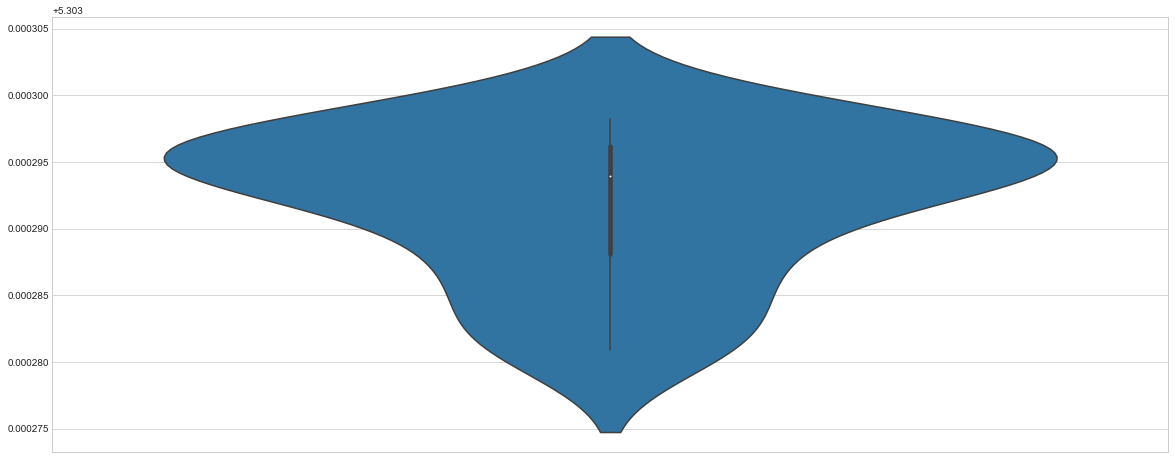

In [29]:
all_entropies = []
all_entropies.extend(healthy_entropies)
all_entropies.extend(sick_entropies)
plot_entropies(all_entropies)

### Entropia inter-electrodo
Para esto decidi calcular la entropia conjunta de los electrodos 31 y 145, porque uno esta en la frente y otro en la nuca y me parecio interesante ver cuanta informacion dan en conjunto dos puntos tan alejados.

In [21]:
def mutual_information(variables):
    from scipy.stats import entropy
    all_vars = np.hstack(variables)
    return (sum([entropy(X) for X in variables]) - entropy(all_vars))

def get_mutual_information_31_145(people):
    return [[mutual_information([np.digitize(epoch[31],bins), np.digitize(epoch[145], bins)]) for epoch in person] for person in people]

In [22]:
healthy_info_31_145 = get_mutual_information_31_145(healthy)
sick_info_31_145 = get_mutual_information_31_145(sick)

In [33]:
def plot_mutual_information_31_145(people):
    figsize(20, 8)
    sns.set_style("whitegrid")
    means = [np.sum(person)/len(person) for person in people]
    ax = sns.violinplot(y=means, scale='count')

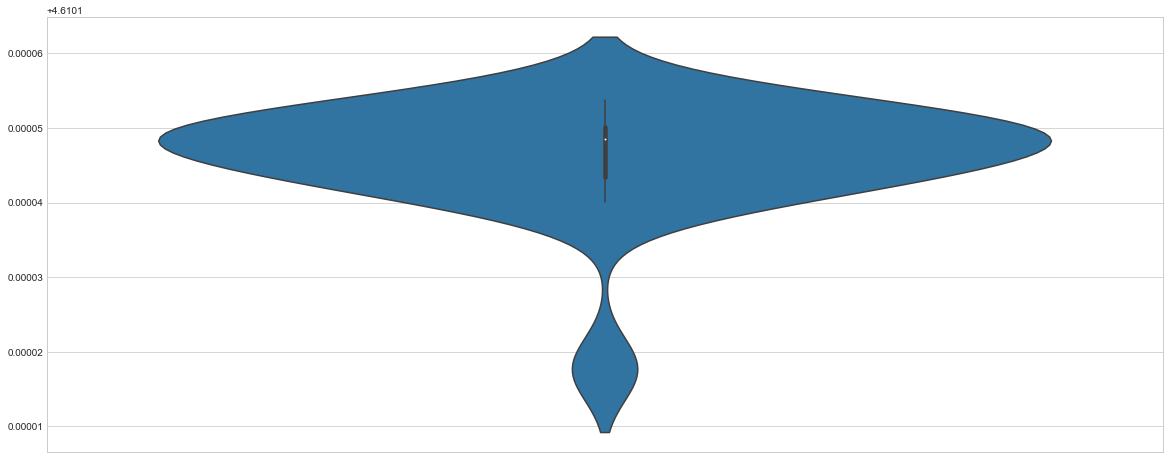

In [34]:
all_mutual_information_31_145 = []
all_mutual_information_31_145.extend(healthy_info_31_145)
all_mutual_information_31_145.extend(sick_info_31_145)
plot_mutual_information_31_145(all_mutual_information_31_145)

In [9]:
[sleep(1) for a in tqdm([2,1,2,3])]

100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


[None, None, None, None]